In [1]:
from IPython.display import Audio
import random
import pickle
import os
os.system("pip install kaggle")

import numpy as np
import pandas as pd
import librosa

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [2]:
np.random.seed(39)
tf.random.set_seed(39)
random.seed(39)

pd.set_option('display.max_columns', 100)

In [3]:
SAMPLE_RATE = 16000
ACCEPTED_FORMATS = ["wav", "WAV"]

DURATION = 3
FRAME_LENGTH_DURATION_IN_MS = 25
FRAME_SKIP_DURATION_IN_MS = 12

N_FFT = 512
HOP_LENGTH = 256

BATCH_SIZE = 8
EPOCHS = 100

DATA_PATH = "E:/Desktop/StutterDetModel/data"

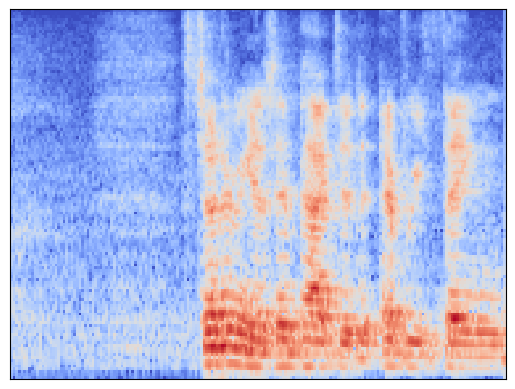

In [4]:
eg_audio = os.path.join(DATA_PATH, "clips/stuttering-clips/clips/FluencyBank_010_0.wav")
audio, sr = librosa.load(eg_audio, sr=16000)
mel_spec = librosa.feature.melspectrogram(
    y=audio,
    sr=sr,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH
)
mel_spec = librosa.power_to_db(mel_spec)
librosa.display.specshow(mel_spec)
Audio(audio, rate=sr)

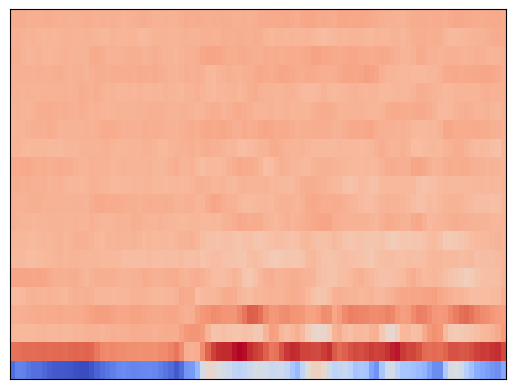

In [5]:
mfcc = librosa.feature.mfcc(
    y=audio,
    sr=sr,
    n_mfcc=20,
)
librosa.display.specshow(mfcc)
Audio(audio, rate=sr)

In [62]:
# def get_data(data_path, df_path, required_cols=['FileName', 'Stutter']):
#     info_df = pd.read_csv(df_path, index_col=0)
#     info_df = info_df.set_index("SEP28k-D")[required_cols]
#     required_cols.remove("FileName")

#     full_data = []
#     for stage in :
#         data = {"MelSpectrogram": []}

#         stage_df = info_df.loc[stage].set_index("FileName")

#         for column_name in required_cols:
#             data[column_name] = []

#         for file_name, info in stage_df.iterrows():
#             audio_path = os.path.join(data_path, file_name)

#             if file_name.split(".")[-1] not in ACCEPTED_FORMATS:
#                 continue

#             try:
#                 audio, _ = librosa.load(audio_path, sr=SAMPLE_RATE, duration=DURATION)
#             except Exception as e:
#                 print(f"\t[-] Audio {file_name} is invalid!")

#             if audio.size < 2*SAMPLE_RATE:
#                 continue
#             elif audio.size < DURATION*SAMPLE_RATE:
#                 pad_size = DURATION*SAMPLE_RATE - audio.size
#                 audio = np.pad(audio, pad_width=(0, pad_size))

#             melspec = librosa.feature.melspectrogram(
#                 y=audio,
#                 sr=SAMPLE_RATE,
#                 n_fft=N_FFT,
#                 hop_length=HOP_LENGTH
#             )
#             melspec = librosa.power_to_db(melspec)[:, :, np.newaxis]
#             data["MelSpectrogram"].append(melspec)
#             for column_name in required_cols:
#                 data[column_name].append(info[column_name])

#         full_data.append(data)
#     return full_data

In [63]:
# def get_data(data_path, df_path, k_fold_no=1, required_cols=['NoStutter']):
#     info_df = pd.read_csv(df_path, index_col=0)
#     info_df = info_df.set_index("FileName")
#     info_df = info_df[required_cols+[f"KFold{k_fold_no}"]]
#     full_data = []
#     for stage in range(1, -1, -1):
#         stage_df = info_df[info_df[f"KFold{k_fold_no}"] == stage]
#         stage_df = stage_df.drop(columns=f"KFold{k_fold_no}")
#         data = {}
#         data["MelSpectrogram"] = []
#         for column in required_cols:
#             data[column] = []

#         for file_name, info in stage_df.iterrows():
#             audio_path = os.path.join(data_path, file_name)
#             if file_name.split(".")[-1] not in ACCEPTED_FORMATS:
#                 continue

#             try:
#                 audio, _ = librosa.load(audio_path, sr=SAMPLE_RATE, duration=DURATION)
#             except Exception as e:
#                 print(f"\t[-] Audio {file_name} is invalid!")
#                 continue
#             if audio.size < 2*SAMPLE_RATE:
#                 continue
#             elif audio.size < DURATION*SAMPLE_RATE:
#                 pad_size = DURATION*SAMPLE_RATE - audio.size
#                 audio = np.pad(audio, pad_width=(0, pad_size))
#             elif audio.size > DURATION*SAMPLE_RATE:
#                 audio = audio[:DURATION*SAMPLE_RATE]

#             melspec = librosa.feature.melspectrogram(
#                 y=audio,
#                 sr=SAMPLE_RATE,
#                 n_fft=N_FFT,
#                 hop_length=HOP_LENGTH
#             )
#             melspec = librosa.power_to_db(melspec)[:, :, np.newaxis]
#             data["MelSpectrogram"].append(melspec)
#             for column_name in required_cols:
#                 data[column_name].append(info[column_name])
#         full_data.append(data)
#     return full_data

In [64]:
# required_cols = [ 'Prolongation', 'Block', 'Interjection', 'Repetition', 'NoStutter']

# for i in range(1, 6):
#     if os.path.exists(rf"E:\Desktop\StutterDetModel\Tensorflow_models\saved_data\kfold{i}.pkl"):
#         with open(rf"E:\Desktop\StutterDetModel\Tensorflow_models\saved_data\kfold{i}.pkl", "rb") as f:
#             data = pickle.load(f)
#     else:
#         data = get_data(
#             os.path.join(DATA_PATH, "clips/stuttering-clips/clips"), 
#             os.path.join(DATA_PATH, "KFold_dataset.csv"),
#             k_fold_no=i,
#             required_cols=required_cols
#         )
#         with open(rf"E:\Desktop\StutterDetModel\Tensorflow_models\saved_data\kfold{i}.pkl", "wb") as f:
#             pickle.dump(data, f)
#     del data
#     print("Finished: ", rf"E:\Desktop\StutterDetModel\Tensorflow_models\saved_data\kfold{i}.pkl")

In [6]:
with open(rf"E:\Desktop\StutterDetModel\Tensorflow_models\saved_data\kfold{1}.pkl", "rb") as f:
    train, val = pickle.load(f)

In [7]:
train_melspec = np.array(train["MelSpectrogram"])
mel_spec_mean = train_melspec.mean()
mel_spec_std = train_melspec.std()
print(mel_spec_mean, mel_spec_std, train_melspec.min(), train_melspec.max())

-42.745132 16.253246 -100.0 26.269497


In [8]:
val_melspec = np.array(val["MelSpectrogram"])

In [9]:
del train["MelSpectrogram"], val["MelSpectrogram"]

In [10]:
# Standardize the mel spectrograms

train_melspec = (train_melspec - mel_spec_mean) / mel_spec_std
val_melspec = (val_melspec - mel_spec_mean) / mel_spec_std

In [11]:
val_melspec.min(), val_melspec.max()

(-3.4893186, 4.280194)

In [12]:
label = np.array(train["NoStutter"])
num_pos = label.sum()
num_neg = len(label) - num_pos
alpha_val = num_neg / num_pos
print(num_pos, num_neg)
alpha_val

1720.0 2254.0


1.3104651162790697

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_melspec,
     np.expand_dims(np.array(train["NoStutter"]), axis=-1))
)
val_ds = tf.data.Dataset.from_tensor_slices(
    (val_melspec,
     np.expand_dims(np.array(val["NoStutter"]), axis=-1))
)

In [14]:
del train, val

In [15]:
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [31]:
model = Sequential([
    layers.Input((128, 188, 1)),
    layers.Conv2D(32, 
                kernel_size=3, 
                strides=1, 
                dilation_rate=2, 
                kernel_regularizer=tf.keras.regularizers.L2(l1=0.01),
                activation="relu"
                ),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Conv2D(64, 
                kernel_size=3, 
                strides=1, 
                dilation_rate=4,
                kernel_regularizer=tf.keras.regularizers.L2(l1=0.01),
                activation="relu"
                ),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Conv2D(128, 
                kernel_size=3, 
                strides=1, 
                dilation_rate=8,
                kernel_regularizer=tf.keras.regularizers.L2(l1=0.01),
                activation="relu"
                ),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Conv2D(256, 
                kernel_size=3, 
                strides=1, 
                dilation_rate=16,
                kernel_regularizer=tf.keras.regularizers.L2(l1=0.01),
                activation="relu"
                ),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 124, 184, 32)      320       
                                                                 
 batch_normalization_12 (Bat  (None, 124, 184, 32)     128       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 124, 184, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 116, 176, 64)      18496     
                                                                 
 batch_normalization_13 (Bat  (None, 116, 176, 64)     256       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 116, 176, 64)     

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-3, 
        amsgrad=True
    ),
    loss=tf.keras.losses.BinaryCrossentropy(
        from_logits=True,
    ),
    metrics=[metrics.BinaryAccuracy(), metrics.Precision(), metrics.Recall()]
)

In [33]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=5,
    verbose=1,
    callbacks=[
        callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)
    ],
    validation_data=val_ds,
    shuffle=True,
).history

Epoch 1/5


497/497 [==============================] - 93s 182ms/step - loss: 5.5378 - binary_accuracy: 0.5561 - precision_2: 0.4513 - recall_2: 0.1186 - val_loss: 1.1753 - val_binary_accuracy: 0.5624 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/5
497/497 [==============================] - 91s 183ms/step - loss: 1.0697 - binary_accuracy: 0.5672 - precision_2: 0.5000 - recall_2: 5.8140e-04 - val_loss: 1.0518 - val_binary_accuracy: 0.5624 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/5
497/497 [==============================] - 93s 188ms/step - loss: 1.0602 - binary_accuracy: 0.5669 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0669 - val_binary_accuracy: 0.5624 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/5
497/497 [==============================] - 319s 642ms/step - loss: 1.0520 - binary_accuracy: 0.5672 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0360 - val_binary_accuracy: 0.5624 - val_precision_2: 0.0

In [29]:
model.evaluate(val_ds)

124/124 [==============================] - 8s 67ms/step - loss: 1.0693 - binary_accuracy: 0.5624 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00


[1.0692867040634155, 0.5624365210533142, 0.0, 0.0]

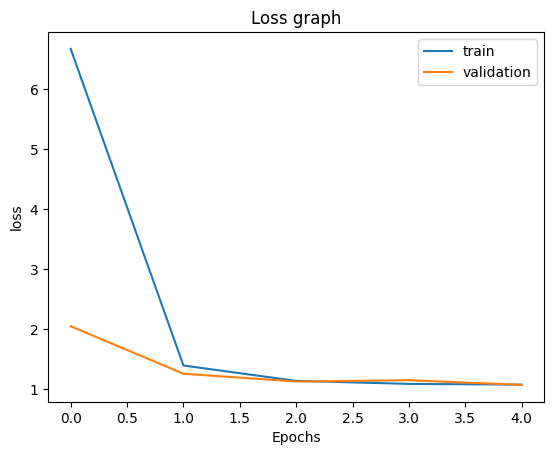

In [30]:
import matplotlib.pyplot as plt

plt.title("Loss graph")
plt.plot(history["loss"], label="train")
plt.plot(history["val_loss"], label="validation")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
inps, outs = next(test_ds.as_numpy_iterator())

In [ ]:
inp1, out1 = inps[0], outs[0]

In [ ]:
np.round(model(inps).numpy().reshape(-1)).astype(np.int32)

In [ ]:
outs.astype(np.int32)

1.0    2138
2.0    1946
0.0    1383
3.0     758
4.0      95
Name: Stutter, dtype: int64